# State Construction Task

In [4]:
from datetime import datetime
import itertools
import io

import numpy as np
import scipy.sparse as sp
import scipy as sc
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [5]:
dim = 4

generates equidistributed points on unit nd-sphere (see [here](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf))

In [6]:
def equidistributed_points(dim, dist):
    with np.errstate(divide='ignore'):
        if np.isnan(dist):
            dist = 4 * np.pi
        if dim == 2:
            phis = np.arange(0, 2 * np.pi, dist)
            return np.vstack([np.cos(phis), np.sin(phis)])
        else:
            slices = []
            for phi in np.arange(0, np.pi, dist):
                proj_points = equidistributed_points(dim - 1, dist / np.sin(phi))
                points = np.vstack([np.full((1, proj_points.shape[1]), np.cos(phi)), np.sin(phi) * proj_points])
                slices.append(points)
            return np.hstack(slices)

## solve using Tensorflow

parametric hamiltonian generator with `tf.Variable`

and a solver

In [7]:
class GradientNorm(tf.train.Optimizer):
    def __init__(self, learning_rate=0.1, use_locking=False, name="GradientNorm"):
        super().__init__(use_locking, name)
        self._lr = learning_rate
        
        # Tensor versions of the constructor arguments, created in _prepare().
        self._lr_t = None

    def _prepare(self):
        self._lr_t = tf.convert_to_tensor(self._lr, name="learning_rate")

    def _apply_dense(self, grad, var):
        lr_t = tf.cast(self._lr_t, var.dtype.base_dtype)
        var_update = tf.assign_sub(var, lr_t * tf.linalg.l2_normalize(grad, axis=1))
        
        return tf.group(*[var_update])

    def _apply_sparse(self, grad, var):
        raise NotImplementedError("Sparse gradient updates are not supported.")

In [27]:
def h_generator(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

def batch_solve_tensorflow(dim, h_generator, source, targets, batch_size):
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.placeholder(dtype='complex128', shape=(batch_size, dim))

        h = h_generator(batch_size)

        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = -tf.reduce_sum(fidelities)
        
        optimizer = GradientNorm(learning_rate=0.5)
        gradients = optimizer.compute_gradients(loss)
        optimize_op = optimizer.minimize(loss)

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        for t in tqdm(targets):
            init_op = tf.global_variables_initializer()
            session.run(init_op)
            for i in range(20): # todo, improve stop
                session.run(optimize_op, feed_dict={target: t})

            yield session.run(fidelities, feed_dict={target: t})

## solve using NumPy

In [33]:
angle = 0.4
replica = 2
batch_size = 1024

source = np.array([1] + [0] * (dim - 1))
map_points = equidistributed_points(2 * dim, angle).T
targets = map_points[:, :dim] + 1j * map_points[:, dim:]
targets_count = targets.shape[0]
print('count: ', targets_count * replica)

ts = np.repeat(targets, replica, axis=0)
if (targets_count * replica) % batch_size:
    ts = np.vstack([ts, np.zeros((batch_size - ((targets_count * replica) % batch_size), dim))])
ts = np.split(ts, ts.shape[0] // batch_size)

res = list(batch_solve_tensorflow(dim, h_generator, source, ts, batch_size))

res = np.vstack(res)
res = np.squeeze(res)
res = res[:targets_count * replica]
res = res.reshape((targets_count, replica))
fidelities = np.max(res, axis=1)

count:  45198


In [30]:
f_min = fidelities.min()
d = np.cos(angle)
MGF = (np.sqrt(d * f_min) - np.sqrt((1 - d) * (1 - f_min))) ** 2

print('d: ', d)
print('minimum fidelity: ', f_min)
print('average fidelity: ', fidelities.mean())
print('MGF: ', MGF)

d:  0.9210609940028851
minimum fidelity:  0.19875607150488508
average fidelity:  0.9391040884158373
MGF:  0.031105790641502883


In [31]:
worst = targets[fidelities.argmin(),:]
worst = np.repeat(np.expand_dims(worst, axis=0), 1024, axis=0)
worst_fidelity = list(batch_solve_tensorflow(dim, h_generator, source, [worst], 1024))[0]

worst state:  [-0.02919952-0.21578074j -0.02986901+0.13916064j -0.41737021-0.27312877j
  0.22360599+0.79594683j]


(array([9.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.011e+03]),
 array([0.19089868, 0.27159253, 0.35228639, 0.43298025, 0.51367411,
        0.59436797, 0.67506183, 0.75575569, 0.83644955, 0.9171434 ,
        0.99783726]),
 <a list of 10 Patch objects>)

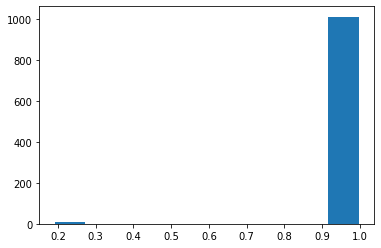

In [32]:
print('worst state: ', targets[fidelities.argmin(),:])
plt.hist(np.squeeze(np.vstack(worst_fidelity)))

implement heisenberg model

In [94]:
basis = [0b100, 0b010, 0b001]

# external field
diag = lambda i : np.diag([(b >> i) & 1 for b in basis])

# coupling
def nondiag(i):
    [[if (a ^ b) >> for b in basis] for a in basis]
            

In [ ]:
def h_generator(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h